In [55]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Code

In [56]:
from GArDen.interfaces import convert, transform, model, predict
from itertools import izip, islice

In [57]:
# plain molecular graph
def preprocess(fname):
    from GArDen.convert.molecular_graph import MoleculeToGraph
    graphs=transform(fname, program=MoleculeToGraph())
    return list(graphs)

In [58]:
# molecular graphs with cycle detection
def preprocess(fname):
    from GArDen.convert.molecular_graph import MoleculeToGraph
    graphs=transform(fname, program=MoleculeToGraph())
    from GArDen.transform.minimal_cycle_annotation import AnnotateMinimalCycles
    graphs=transform(graphs, program=AnnotateMinimalCycles())
    from GArDen.transform.contraction import Minor, contraction_modifier
    #reduce all 'label' attributes of contracted nodes to a histogram to be written in the 'label' attribute of the resulting graph 
    label_modifier = contraction_modifier(attribute_in='part_name', attribute_out='label', reduction='set_categorical')
    #reduce all 'weight' attributes of contracted nodes using a sum to be written in the 'weight' attribute of the resulting graph 
    weight_modifier = contraction_modifier(attribute_in='weight', attribute_out='weight', reduction='sum')
    modifiers = [label_modifier, weight_modifier]
    priors=dict(nesting=True,  modifiers=[modifiers], weight_scaling_factor=1)
    graphs=transform(graphs, program=Minor(), parameters_priors=priors)
    return list(graphs)

# Experiment

In [59]:
folder = '../../../DATA/'
active_fname = folder + 'AID2401_active.sdf'
inactive_fname = folder + 'AID2401_inactive.sdf'

In [60]:
-

CPU times: user 11.7 s, sys: 511 ms, total: 12.2 s
Wall time: 11.9 s


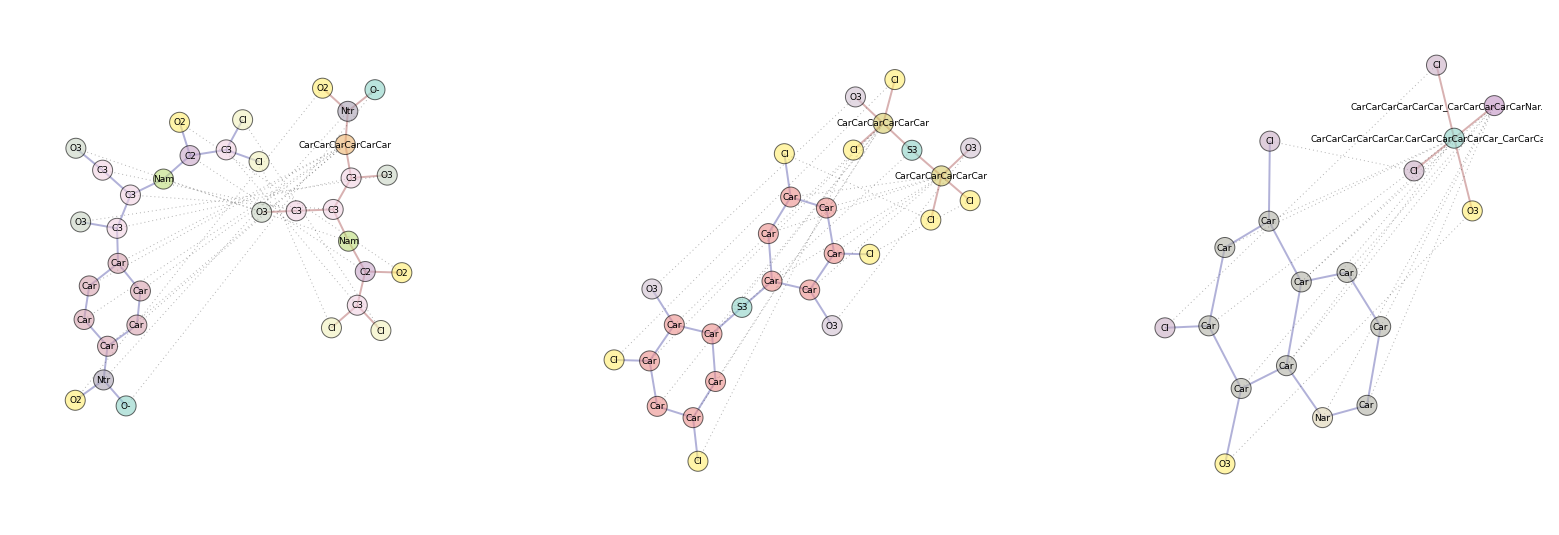

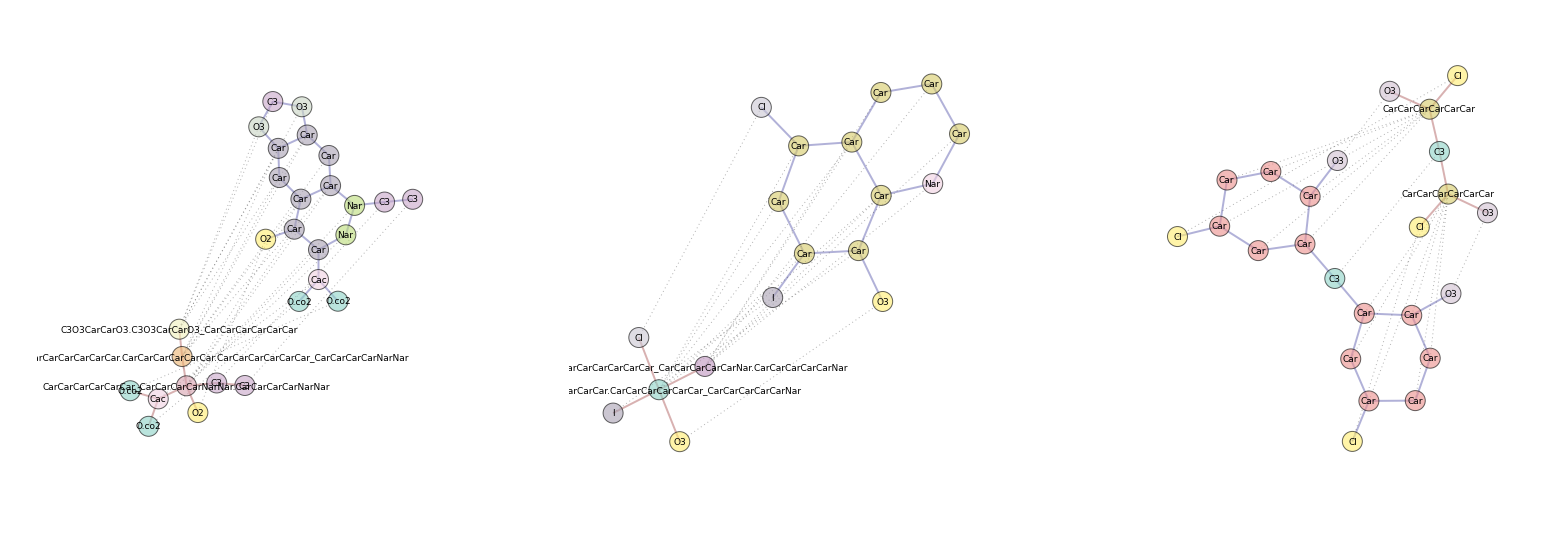

In [61]:
from itertools import tee, islice
train_graphs, train_graphs_ = tee(train_graphs)
# display of graphs
from eden.util.display import draw_graph_set
draw_graph_set(islice(train_graphs, 6), n_graphs_per_line=3, size=9, title_key='id', prog='neato', node_border=1, node_size=400, colormap='Set3', edge_color='_label_',edge_alpha=.3, vertex_label='label', vertex_color='_label_', ignore_for_layout='nesting')

In [62]:
%%time
from sklearn.linear_model import SGDClassifier
parameters_priors=dict(average=True, loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, n_iter=5, shuffle=True, verbose=0, epsilon=0.1, n_jobs=-1, random_state=None, learning_rate='optimal', eta0=0.0, power_t=0.5, class_weight=None, warm_start=False)
parameters_priors.update(dict(vectorizer__r=3,vectorizer__d=5, vectorize__n_jobs=-1, vectorize__fit_flag=False, vectorize__n_blocks=5, vectorize__block_size=None))
predictor = SGDClassifier()
fit_predictor = model(train_graphs, program=predictor, parameters_priors=parameters_priors)

CPU times: user 12.5 s, sys: 1.99 s, total: 14.5 s
Wall time: 28.3 s


In [63]:
%%time
predictions = predict(test_graphs, program=fit_predictor)
y_pred = []
y_score = []
y_test = []
for prediction in predictions:
    y_pred.append(prediction.graph['prediction'])
    y_score.append(prediction.graph['score'])
    y_test.append(prediction.graph['target'])

from sklearn import metrics
import numpy as np
# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print 'Confusion matrix:'
print(cm)

#classification
print(metrics.classification_report(y_test, y_pred))

#roc
print 'ROC: %.3f'%(metrics.roc_auc_score(y_test, y_score))

Confusion matrix:
[[334   7]
 [ 51  55]]
             precision    recall  f1-score   support

         -1       0.87      0.98      0.92       341
          1       0.89      0.52      0.65       106

avg / total       0.87      0.87      0.86       447

ROC: 0.920
CPU times: user 3.22 s, sys: 842 ms, total: 4.07 s
Wall time: 7.63 s


---